<a href="https://colab.research.google.com/github/clepigdo/Latihan_STKI2025/blob/main/DocumentClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# Sklearn Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# NLTK Setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
# Load Data
try:
    df = pd.read_csv('drive/MyDrive/Colab Notebooks/tmdb_5000_movies.csv.gz', compression='gzip')
except:
    # Fallback jika file sudah diextract
    df = pd.read_csv('tmdb_5000_movies.csv')

# Gabungkan Tagline + Overview
df['tagline'] = df['tagline'].fillna('')
df['overview'] = df['overview'].fillna('')
df['description'] = df['tagline'] + ' ' + df['overview']

# Buang data yang deskripsinya kosong
df = df[df['description'].str.strip() != '']
df = df.reset_index(drop=True)

print(f"Data siap: {df.shape[0]} film.")
df[['title', 'description']].head()

Data siap: 4799 film.


,title,description
0,Avatar,Enter the World of Pandora. In the 22nd centur...
1,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins...."
2,Spectre,A Plan No One Escapes A cryptic message from B...
3,The Dark Knight Rises,The Legend Ends Following the death of Distric...
4,John Carter,"Lost in our world, found in another. John Cart..."


In [6]:
# Fungsi Pembersih Simpel
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) # Hapus simbol aneh
    text = text.lower()
    text = text.strip()
    return text

df['clean_desc'] = df['description'].apply(clean_text)

# Konversi Teks ke Angka (TF-IDF)
# min_df=5: Kata harus muncul minimal di 5 film (buang typo)
# max_df=0.8: Kata jangan muncul di >80% film (buang kata pasaran)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5, max_df=0.8)
tfidf_matrix = tfidf.fit_transform(df['clean_desc'])

print(f"Dimensi Matrix: {tfidf_matrix.shape}")

Dimensi Matrix: (4799, 5000)


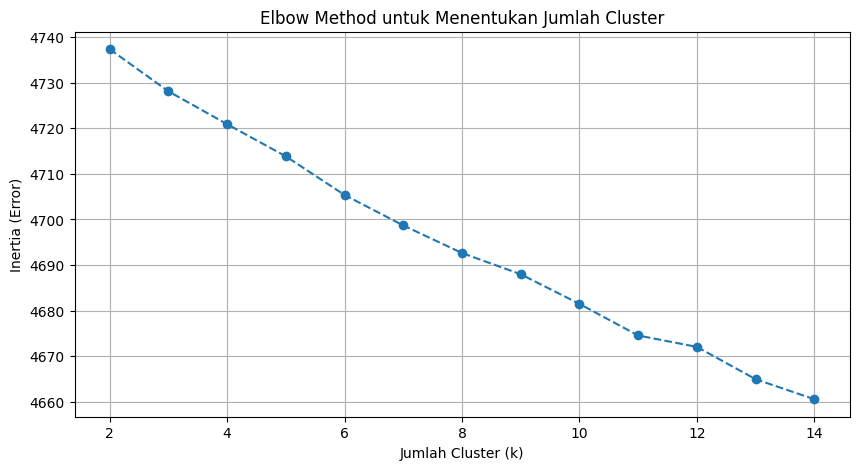

In [7]:
inertia = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(tfidf_matrix)
    inertia.append(km.inertia_)

# Plot Elbow
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Error)')
plt.grid(True)
plt.show()

In [8]:
OPTIMAL_K = 8

print(f"Melatih K-Means dengan {OPTIMAL_K} cluster...")
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(tfidf_matrix)

# Masukkan hasil ke dataframe
df['kmeans_cluster'] = kmeans_labels
print("K-Means selesai.")

Melatih K-Means dengan 8 cluster...
K-Means selesai.


In [9]:
print("Melatih Hierarchical Clustering")
sample_size = 2000
X_sample = tfidf_matrix[:sample_size].toarray()

agglo = AgglomerativeClustering(n_clusters=OPTIMAL_K)
agglo_labels = agglo.fit_predict(X_sample)

print("Hierarchical Clustering selesai.")

Melatih Hierarchical Clustering
Hierarchical Clustering selesai.


HASIL EKSPERIMEN (Semakin tinggi semakin bagus):
                     Model  Silhouette Score
0         K-Means (TF-IDF)          0.002821
1  Hierarchical Clustering         -0.002477


/tmp/ipython-input-770521869.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison, x='Model', y='Silhouette Score', palette='viridis')


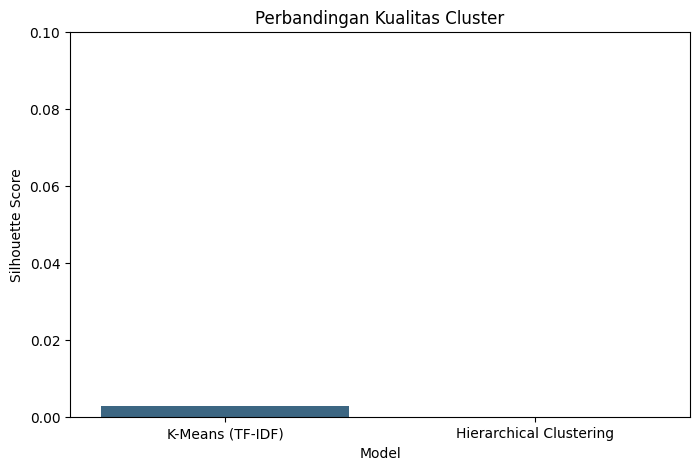

In [10]:
# Hitung Silhouette Score untuk K-Means
score_km = silhouette_score(tfidf_matrix, kmeans_labels)

# Hitung Silhouette Score untuk Hierarchical
score_agg = silhouette_score(X_sample, agglo_labels)

# Tampilkan Tabel Perbandingan
comparison = pd.DataFrame([
    ['K-Means (TF-IDF)', score_km],
    ['Hierarchical Clustering', score_agg]
], columns=['Model', 'Silhouette Score'])

print("HASIL EKSPERIMEN (Semakin tinggi semakin bagus):")
print(comparison)

# Visualisasi Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison, x='Model', y='Silhouette Score', palette='viridis')
plt.title("Perbandingan Kualitas Cluster")
plt.ylim(0, 0.1)
plt.show()

In [11]:
print("CONTOH ISI CLUSTER K-MEANS:")
for i in range(OPTIMAL_K):
    print(f"\nCluster #{i}:")
    movies = df[df['kmeans_cluster'] == i]['title'].head(5).tolist()
    print(f"Film: {movies}")

CONTOH ISI CLUSTER K-MEANS:

Cluster #0:
Film: ['Titanic', 'A Christmas Carol', 'Maleficent', 'The Curious Case of Benjamin Button', 'Frozen']

Cluster #1:
Film: ['Monsters University', 'The Amazing Spider-Man 2', 'Spider-Man', 'Grown Ups', 'Anna and the King']

Cluster #2:
Film: ['Spectre', 'The Dark Knight Rises', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron']

Cluster #3:
Film: ['Avatar', "Pirates of the Caribbean: At World's End", 'John Carter', 'Batman v Superman: Dawn of Justice', 'Man of Steel']

Cluster #4:
Film: ['The Chronicles of Narnia: Prince Caspian', 'Transformers: Revenge of the Fallen', 'The Legend of Tarzan', 'Up', 'Inside Out']

Cluster #5:
Film: ['Hugo', 'How to Train Your Dragon', 'Poseidon', 'Pearl Harbor', 'War of the Worlds']

Cluster #6:
Film: ['Robin Hood', 'Furious 7', 'Warcraft', 'Dark Shadows', 'The Twilight Saga: Breaking Dawn - Part 2']

Cluster #7:
Film: ['Transformers: Dark of the Moon', 'The Lovers', 'The Aviator', 'The Tourist', "Legend of the 

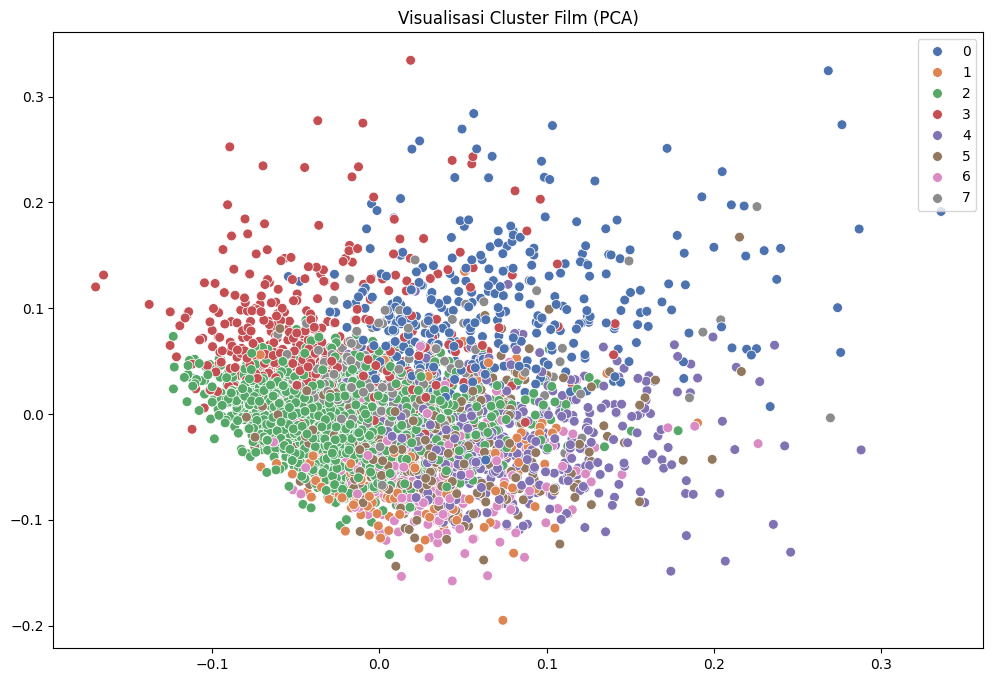

In [12]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(tfidf_matrix.toarray())

colors = ["#4EACC5", "#FF9C34", "#4E9A06", "red", "purple", "blue", "yellow", "black"]

plt.figure(figsize=(12, 8))
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

sns.scatterplot(x=x_axis, y=y_axis, hue=kmeans_labels, palette="deep", s=50)
plt.title('Visualisasi Cluster Film (PCA)')
plt.show()